In [1]:
# https://pyportfolioopt.readthedocs.io/
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as n
import pandas as pd
import datetime
import pypfopt
import warnings
from pypfopt import risk_models
from pypfopt import plotting
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions
from pypfopt import DiscreteAllocation
import cvxpy
import cvxopt
import collections
from collections import OrderedDict, Counter
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  # default='warn

In [6]:
tickers = ['NLMK.ME', 'MAGN.ME', 'YNDX.ME', 'RUAL.ME', 'FEES.ME', 'GAZP.ME', 'IRAO.ME']

In [7]:
ohlc = yf.download(tickers, start='2017-01-01', end='2020-12-31')

[*********************100%***********************]  7 of 7 completed


In [8]:
prices = ohlc["Adj Close"].dropna(how="all")
prices.tail()

,FEES.ME,GAZP.ME,IRAO.ME,MAGN.ME,NLMK.ME,RUAL.ME,YNDX.ME
Date,,,,,,,
2020-12-24,0.197316,196.395081,5.088188,49.237907,178.580826,34.700001,5000.000000
2020-12-25,0.200733,196.701447,5.120032,50.721058,182.227997,34.730000,5048.000000
2020-12-28,0.207715,197.132248,5.114242,50.813213,184.063614,35.654999,5013.000000
2020-12-29,0.208179,200.109680,5.148015,50.190109,176.017090,35.564999,5044.600098
2020-12-30,0.206230,203.316864,5.128234,49.018513,174.592194,35.294998,5157.200195


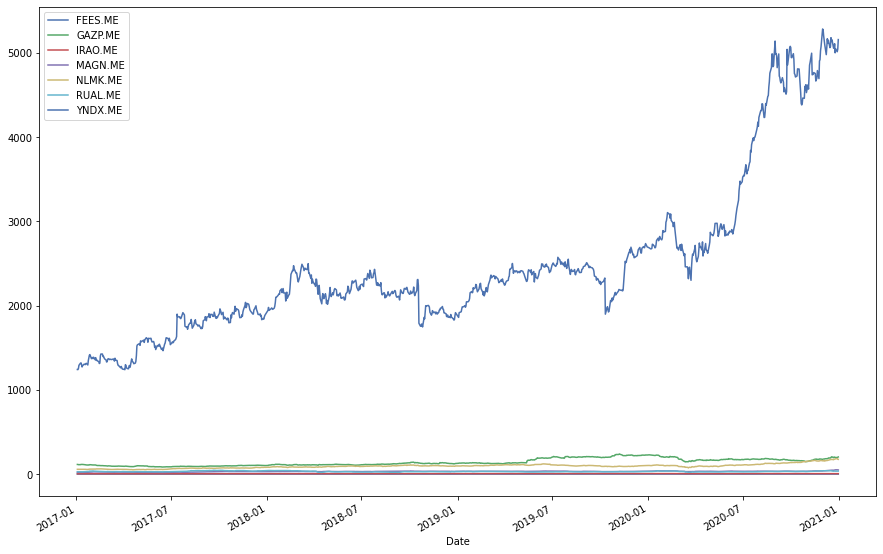

In [9]:
prices[prices.index >= "2008-01-01"].plot(figsize=(15,10));

## Calculating the covariance matrix


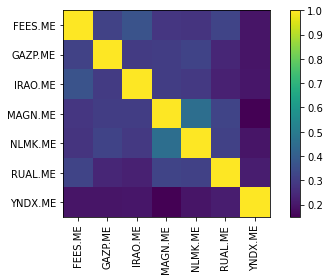

In [10]:
#S = risk_models.sample_cov(prices, frequency=252) #Используется в эмпириале, простая ковариционная матрица
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
#S = risk_models.exp_cov(prices, returns_data=False, span=180, frequency=252, log_returns=False) #Экспоненциальная матрица
plotting.plot_covariance(S, plot_correlation=True);

## Return estimation

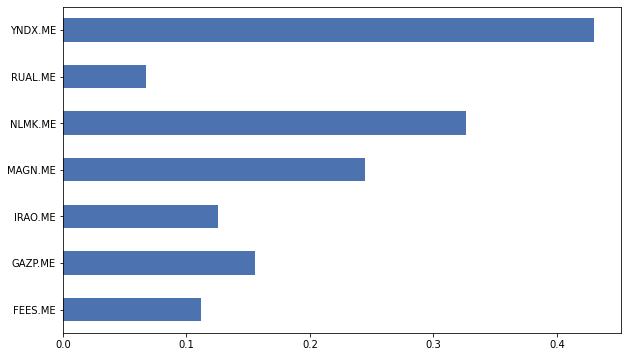

In [11]:
#mu = expected_returns.capm_return(prices) # Модель CAPM для ожидаемой доходности
mu = expected_returns.mean_historical_return(prices, returns_data=False, compounding=True, frequency=252, log_returns=False) # историческая доходность используется в эмпирикале
#mu = expected_returns.ema_historical_return(prices, returns_data=False, compounding=True, span=126, frequency=252, log_returns=False) # экспоненциальная доходность, больше веса последним значениям
mu.plot.barh(figsize=(10,6));                                                    

In [12]:
ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
#ef.save_weights_to_file("weights.txt")  # saves to file
print(cleaned_weights)

OrderedDict([('FEES.ME', 0.0), ('GAZP.ME', 0.08115), ('IRAO.ME', 0.01273), ('MAGN.ME', 0.19182), ('NLMK.ME', 0.32776), ('RUAL.ME', 0.0), ('YNDX.ME', 0.38655)])


In [13]:
df = pd.DataFrame.from_dict(cleaned_weights, orient='index').reindex(tickers).T
df

,NLMK.ME,MAGN.ME,YNDX.ME,RUAL.ME,FEES.ME,GAZP.ME,IRAO.ME
0,0.32776,0.19182,0.38655,0.0,0.0,0.08115,0.01273


In [14]:
ef.portfolio_performance(verbose=True)

Expected annual return: 33.5%
Annual volatility: 20.9%
Sharpe Ratio: 1.50


(0.33458485677901484, 0.2094911600529041, 1.5016617250082092)

In [15]:
latest_prices = prices.iloc[-1]  # prices as of the day you are allocating
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=100000)
alloc, leftover = da.lp_portfolio()
print(f"Discrete allocation performed with ${leftover:.2f} leftover")
alloc = pd.DataFrame.from_dict(alloc, orient='index').reindex(tickers).fillna(0).T
alloc

Discrete allocation performed with $2451.40 leftover


,NLMK.ME,MAGN.ME,YNDX.ME,RUAL.ME,FEES.ME,GAZP.ME,IRAO.ME
0,188.0,392.0,7.0,0.0,0.0,40.0,249.0


### Бэктест квартальной ребелансировки

In [2518]:
tickers = ['RUAL.ME', 'VTBR.ME', 'TCSG.ME', 'SBER.ME', 'SBERP.ME', 'CBOM.ME', 'MOEX.ME']
prices = yf.download(tickers)["Adj Close"].dropna()                       # Получаем все возможные данные компаний

[*********************100%***********************]  7 of 7 completed


In [2537]:
start = pd.to_datetime('2019-01-01') # Начало периода обучения
end = pd.to_datetime('2019-12-31')   # Конец периода обучения
quarters = 4                         # Количество кварталов ребалансировки после обучения
capital = 1000000

In [2542]:
weights_df = pd.DataFrame(columns=tickers)
loc_start = start
loc_end = end
for i in range(quarters):
    learn_prices = prices.loc[loc_start:loc_end]
    S = risk_models.CovarianceShrinkage(learn_prices).ledoit_wolf()
    mu = expected_returns.ema_historical_return(learn_prices, returns_data=False, compounding=True, span=126, frequency=252, log_returns=False)
    #mu = expected_returns.mean_historical_return(learn_prices, returns_data=False, compounding=True, frequency=252, log_returns=False)
    #mu = expected_returns.capm_return(learn_prices) # Модель CAPM для ожидаемой доходности
    ef = EfficientFrontier(mu, S)
    ef.add_objective(objective_functions.L2_reg, gamma=0.1)
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    prom = pd.DataFrame.from_dict(cleaned_weights, orient='index').reindex(tickers).T
    weights_df = weights_df.append(prom.loc[0])
    #print(loc_start)
    #print(loc_end)
    loc_start = loc_start + datetime.timedelta(days=91.25)
    loc_end = loc_end + datetime.timedelta(days=91.25)
weights_df = weights_df.reset_index()
#weights_df

In [2543]:
# weights_df = pd.DataFrame(columns=tickers)
# for i in range(quarters):   
#     weights_df.loc[i] = [1/len(tickers) for x in range(len(tickers))]
# weights_df = weights_df
# weights_df

In [2544]:
df = prices.loc[end:]
df = df.asfreq(freq='BQ', method='ffill').append(df.iloc[0]).sort_index()
df = df.drop_duplicates(keep='first')
#df.head()

In [2545]:
df['P&L'] = ''
df['P&L'][0] = capital
df['Cash'] = ''
for ticker in tickers:
    df[f'{ticker} count'] = ''
    df[f'{ticker} equity'] = ''
    
for i in range(quarters): 
    prom_equity = 0
    prom_pl = 0
    for ticker in tickers:
        df[f'{ticker} count'][i] = int(df['P&L'][i] * weights_df[ticker][i] / df[ticker][i])
        df[f'{ticker} equity'][i] = df[f'{ticker} count'][i] * df[ticker][i]
        prom_equity += df[f'{ticker} equity'][i]
        prom_pl += df[ticker][i+1] * df[f'{ticker} count'][i]
    df['Cash'][i] = df['P&L'][i] - prom_equity
    df['P&L'][i+1] = prom_pl
print("Доходность за", quarters, "кварталов", "Составила", round(((df['P&L'][quarters]-df['P&L'][0])/df['P&L'][0])*100, 2), "%")

Доходность за 4 кварталов Составила -21.62 %


In [2524]:
# df['P&L'] = ''
# df['P&L'][0] = capital
# df['Cash'] = ''
# for ticker in tickers:
#     df[f'{ticker} count'] = ''
#     df[f'{ticker} equity'] = ''
# quarters=4   
# prom_equity = 0
# prom_pl = 0
# for ticker in tickers:
#     df[f'{ticker} count'][0] = int(df['P&L'][0] * weights_df[ticker][0] / df[ticker][0])
#     df[f'{ticker} equity'][quarters] = df[f'{ticker} count'][0] * df[ticker][quarters]
#     prom_pl += df[f'{ticker} equity'][quarters]
# df['P&L'][quarters] = prom_pl
# print("Доходность за", quarters, "кварталов", "Составила", round(((df['P&L'][quarters]-df['P&L'][0])/df['P&L'][0])*100, 2), "%")

Доходность за 4 кварталов Составила 36.86 %


In [2437]:
df['P&L']

Date
2017-01-03        1000000
2017-03-31    1.27773e+06
2017-06-30    1.38673e+06
2017-09-29    1.39718e+06
2017-12-29    1.74644e+06
2018-03-30               
2018-06-29               
2018-09-28               
2018-12-31               
2019-03-29               
2019-06-28               
2019-09-30               
2019-12-31               
2020-03-31               
2020-06-30               
2020-09-30               
2020-12-31               
2021-03-31               
2021-06-30               
2021-09-30               
Name: P&L, dtype: object

In [2403]:
prices = yf.download(tickers)["Adj Close"]

[*********************100%***********************]  35 of 35 completed


In [2404]:
prices.loc['2017'].iloc[0].dropna().index.tolist()

['AFN.TO',
 'AT.TO',
 'AXU.TO',
 'BDT.TO',
 'CAS.TO',
 'CFX.TO',
 'CGO.TO',
 'CMMC.TO',
 'DIV.TO',
 'DPM.TO',
 'DR.TO',
 'DRT.TO',
 'EXE.TO',
 'GSC.TO',
 'IBG.TO',
 'IMG.TO',
 'JAG.TO',
 'MAL.TO',
 'MRE.TO',
 'OBE.TO',
 'PBL.TO',
 'PHX.TO',
 'QTRH.TO',
 'SIS.TO',
 'SVM.TO',
 'TCS.TO',
 'TLG.TO',
 'TRZ.TO',
 'TXP.TO',
 'USA.TO',
 'VGCX.TO',
 'WEF.TO',
 'XTC.TO']

In [2405]:
prices.loc['2017'].iloc[0].index.tolist()

['AFN.TO',
 'AT.TO',
 'AXU.TO',
 'BDT.TO',
 'CAS.TO',
 'CFX.TO',
 'CGO.TO',
 'CMMC.TO',
 'DIV.TO',
 'DPM.TO',
 'DR.TO',
 'DRT.TO',
 'EXE.TO',
 'GSC.TO',
 'IBG.TO',
 'IMG.TO',
 'JAG.TO',
 'MAL.TO',
 'MRE.TO',
 'NUAG.TO',
 'OBE.TO',
 'PBL.TO',
 'PHX.TO',
 'QTRH.TO',
 'SIS.TO',
 'SVM.TO',
 'TCS.TO',
 'TLG.TO',
 'TRZ.TO',
 'TXP.TO',
 'USA.TO',
 'VGCX.TO',
 'VLNS.TO',
 'WEF.TO',
 'XTC.TO']

In [1399]:
weights = [1/len(tickers) for x in range(len(tickers))]

In [1400]:
weights

[0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.010416666666666666,
 0.01041666

In [1420]:
k = 1/len(tickers)
# Calculate weights of each equity
count = []
for ticker in tickers:
    count.append(int((capital*k)/df[ticker][0]))
count

cash = capital - (df.loc[end:].iloc[0]*count).sum()

PL = []
for i in range(quarters):
    PL.append((df.iloc[i]*count).sum()+cash)
# df['P&L'] = PL
# df['P&L returns'] = prices['P&L'].pct_change()
# df = df.dropna()
print("Доходность за", quarters, "кварталов", "Составила", round((PL[-1]-PL[0])/PL[0]*100, 2), "%")

Доходность за 4 кварталов Составила 13.17 %


In [1418]:
df

,A,ABT,ADBE,ADSK,AIG,AMCR,AMD,AMZN,ANET,ANSS,...,VMC,VRSN,VRTX,WFC,WST,WY,XRAY,YUM,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,65.609711,55.057594,177.699997,107.120003,52.874176,9.860752,10.980000,1189.010010,57.757500,148.550003,...,126.910469,109.470001,152.910004,54.121727,97.926628,30.586048,65.149818,76.112846,45.440060,70.102852
2018-03-30,64.930336,56.384212,216.080002,125.580002,48.638103,9.153026,10.050000,1447.339966,63.825001,156.690002,...,110.128822,118.559998,162.979996,46.708748,87.018425,30.605696,48.904709,79.773315,47.442066,81.704239
2018-06-29,60.153278,57.667332,243.809998,131.089996,47.666424,8.940165,14.990000,1699.800049,64.372498,174.179993,...,124.764275,137.419998,169.960007,49.781128,98.013298,32.150661,42.632732,73.615128,47.603630,83.470253
2018-09-28,68.781715,69.675224,269.950012,156.110001,48.156788,8.669086,30.889999,2003.000000,66.464996,186.679993,...,107.772964,160.119995,192.740005,47.540478,122.055984,28.739202,36.844666,85.925446,45.563999,89.843376
2018-12-31,66.080719,68.979401,226.240005,128.610001,35.953964,8.102764,18.459999,1501.969971,52.674999,142.940002,...,96.013870,148.289993,165.710007,42.016514,97.035027,19.716957,36.413406,87.240929,37.240475,84.051018
2019-03-29,78.736572,76.590393,266.489990,155.820007,39.573059,9.554510,25.520000,1780.750000,78.614998,182.710007,...,115.374153,181.559998,183.949997,44.458393,109.237198,24.074404,48.615288,95.154236,41.760445,99.112976
2019-06-28,73.292854,80.905846,294.649994,162.899994,49.263115,10.322953,30.370001,1893.630005,64.904999,204.820007,...,134.125839,209.160004,183.380005,43.959198,124.215965,24.430286,57.300446,105.949623,42.559566,111.919792
2019-09-30,75.544464,80.793610,276.250000,147.699997,51.789944,8.868166,28.990000,1735.910034,59.730000,221.360001,...,148.055252,188.630005,169.419998,47.385143,140.933411,26.024071,52.440681,108.985161,41.550739,123.043716
2019-12-31,84.279091,84.210205,329.809998,183.460007,48.027596,9.973022,45.860001,1847.839966,50.849998,257.410004,...,141.269562,192.679993,218.949997,51.025349,149.561020,28.702501,55.764664,97.199059,48.784214,130.874954


In [1408]:
prices.loc[end:].iloc[0]

A        65.609711
ABT      55.057594
ADBE    177.699997
ADSK    107.120003
AIG      52.874176
           ...    
WY       30.586048
XRAY     65.149818
YUM      76.112846
ZION     45.440060
ZTS      70.102852
Name: 2018-01-02 00:00:00, Length: 96, dtype: float64